In [ ]:
pip install 123-object-detection

In [7]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

ModuleNotFoundError: No module named 'tensorflow'

#### Need to clone repo when using colab

In [ ]:
!git clone https://github.com/Slimmerd/car-detection.git

## Defining Paths and links

In [8]:
# TODO Paste your pre-trained model url
PRET_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'

MAIN_PATH = os.getcwd() + '/car-detection'
MODEL_PATH = MAIN_PATH +'/models'
UTILS_PATH = MAIN_PATH + '/utils'

DATASET_PATH = MAIN_PATH + '/dataset'
DATASET_NAME = 'object-detection-crowdai'

PRET_MODEL_PATH = MAIN_PATH + '/models/pretrained'
CUST_MODEL_PATH = MAIN_PATH + '/models/custom'

# TODO Paste your pre-trained model name
PRET_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
# TODO Name your custom model
CUST_MODEL_NAME = 'custom_based_tpu8'

CFG_PATH = CUST_MODEL_PATH + '/' + CUST_MODEL_NAME + '/pipeline.config'

## Download dataset and pre-trained model

In [3]:
# Creating folders and downloading, unpacking dataset

!mkdir {DATASET_PATH}
!cd {DATASET_PATH} && wget https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz
!cd {DATASET_PATH} && tar xf {DATASET_NAME +'.tar.gz'}

In [5]:
# Creating folders and downloading, unpacking pre-trained model

!mkdir {MODEL_PATH}
!mkdir {PRET_MODEL_PATH}

!cd {PRET_MODEL_PATH} && wget {PRET_MODEL_URL}
!cd {PRET_MODEL_PATH} && tar xf {PRET_MODEL_NAME+'.tar.gz'}

mkdir: /Users/nrk/Desktop/car-detection/models: File exists
mkdir: /Users/nrk/Desktop/car-detection/models/pretrained: File exists
mkdir: /Users/nrk/Desktop/car-detection/models/custom: File exists


In [ ]:
# Creating folders and copying pipeline config

!mkdir {CUST_MODEL_PATH}
!mkdir {CUST_MODEL_PATH + '/' + CUST_MODEL_NAME}
!cp {PRET_MODEL_PATH +'/' + PRET_MODEL_NAME + '/pipeline.config'} {CUST_MODEL_PATH + '/' + CUST_MODEL_NAME}


## Divide dataset to train and test datasets

In [5]:
ds = pd.read_csv(UTILS_PATH + '/labels_crowdai.csv')
ds.head()

,xmin,ymin,xmax,ymax,Frame,Label,Preview URL
0,785,533,905,644,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
1,89,551,291,680,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
2,268,546,383,650,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
3,455,522,548,615,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
4,548,522,625,605,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...


In [7]:
gb = ds.groupby('Frame')
gb_list = [gb.get_group(x) for x in gb.groups]

# TODO Amount of unique frames in dataset
#(max size 9218, test and train should be 20% different train < test)
train_index = np.random.choice(len(gb_list), size=4609, replace=False)
test_index = np.setdiff1d(list(range(5530)), train_index)

In [ ]:
len(train_index), len(test_index)

In [ ]:
train = pd.concat([gb_list[i] for i in train_index])
test = pd.concat([gb_list[i] for i in test_index])
len(train), len(test)

# Creating separate datasets
train.to_csv(DATASET_PATH + '/train_labels.csv', index=None)
test.to_csv(DATASET_PATH + '/test_labels.csv', index=None)

## Creating Label map

In [23]:
labels = [{'name':'Car', 'id':1}, {'name':'Truck', 'id':2}, {'name':'Pedestrian', 'id':3}]

with open(DATASET_PATH + '/label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

## Creating TFRecords

In [8]:
!python {UTILS_PATH + '/TFRecord.py'} -image_dir {DATASET_PATH + '/' + DATASET_NAME} -csv_input {DATASET_PATH + '/train_labels.csv'} -output_path {DATASET_PATH + '/train.record'}
!python {UTILS_PATH + '/TFRecord.py'} -image_dir {DATASET_PATH + '/' + DATASET_NAME} -csv_input {DATASET_PATH + '/test_labels.csv'} -output_path {DATASET_PATH + '/test.record'}

2021-12-03 12:27:32.853761: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Successfully created the TFRecords: /content/train.record
2021-12-03 12:27:37.971722: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Successfully created the TFRecords: /content/test.record


## Configuring config

In [19]:
cfg = config_util.get_configs_from_pipeline_file(CFG_PATH)

In [ ]:
cfg

In [20]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CFG_PATH, "r") as f:
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [22]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = PRET_MODEL_PATH +'/' + PRET_MODEL_NAME +'/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= DATASET_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [DATASET_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = DATASET_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [DATASET_PATH + '/train.record']

In [24]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CFG_PATH, "wb") as f:
    f.write(config_text)  

## Train model

In [ ]:
TRAINER = UTILS_PATH + '/model_main_tf2.py'
# Recommended amount of steps is 5000, however it depends on your hardware performance
# Minimum amount get a normal results is 2000
train_command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINER, CUST_MODEL_PATH + '/' + CUST_MODEL_NAME,CFG_PATH)

In [ ]:
print(train_command)

2021-12-03 12:48:09.199141: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
W1203 12:48:09.201333 140388668974976 cross_device_ops.py:1387] There are non-GPU devices in `tf.distribute.Strategy`, not using nccl allreduce.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
I1203 12:48:09.203115 140388668974976 mirrored_strategy.py:376] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 2000
I1203 12:48:09.216774 140388668974976 config_util.py:552] Maybe overwriting train_steps: 2000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I1203 12:48:09.217096 140388668974976 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W1203 12:48:09.530461 140388668974976 deprecation.py:347] From /usr/local/

In [ ]:
!{train_command}

## Export model

In [ ]:
!tar -czf models.tar.gz {CUST_MODEL_PATH + '/' + CUST_MODEL_NAME}

In [ ]:
# Open files folder in colab and transfer your model to drive/MyDrive if you want to save it
from google.colab import drive
drive.mount('/content/drive')

## Import model

In [ ]:
# Don't forget change CUST_MODEL_NAME to the model you importing (if you didn't)

In [ ]:
!tar -zxvf {'models'+'.tar.gz'}

## Load Model

In [13]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [15]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(CFG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)

# Check how many checkpoints in your model it might be ckpt-2, ckpt-5 etc
# Select highest
ckpt.restore(CUST_MODEL_PATH + '/' + CUST_MODEL_NAME + '/ckpt-3').expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

## Detect from picture

In [28]:
import cv2
import numpy as np
from PIL import Image

In [31]:
category_index = label_map_util.create_category_index_from_labelmap(DATASET_PATH + '/label_map.pbtxt')

# TODO You can add your image if so you should change path to your image
# IMAGE_PATH = DATASET_PATH + '/' + DATASET_NAME +'/1479498372942264998.jpg'
IMAGE_PATH = DATASET_PATH + '/test2.jpg'

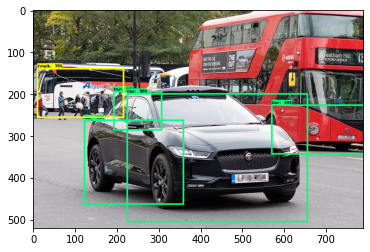

In [47]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.7,
            agnostic_mode=False)

Image.fromarray(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))